In [1]:
import sisl
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline

# TI-01 Spin Texture
In this exercise, we learn how to calculate and plot spin-textures using ```sisl``` and ```SIESTA```, at the example of bismuthene.

## Exercise Overview
1. Create bismuthene geometry.
2. Generate SIESTA Hamiltonian.
3. Calculate the band structure.
4. Calculate the spin texture.

## Exercise

#### 1. Create the geometry in ``sisl`` and save it.
We will consider bismuthene in a buckled hexagonal phase. This crystal structure is similar to the that of graphene. However, the two sublattices form two parallel planes, separated by the buckling height $h$.
We will use an in-plane lattice constant $a$ of $4.60\mathring{\textrm{A}}$ and buckling height $h$ of $1.62\mathring{\textrm{A}}$. The lattice constant for the orthogonal direction $c$ can be large, e.g. $40\mathring{\textrm{A}}$.

|Top view |Side View |
|:--------|:---------|
|<img src="img/Bi2D-BHex-c.png" alt="BHex-c" style="width: 400px;"/>|<img src="img/Bi2D-BHex-a.png" alt="BHex-a" style="width: 400px;"/>|

In [2]:
# Lattice constants
a = 4.60
c = 40.0
# Lattice vectors
a1 = a * np.asarray([1., 0., 0.])
a2 = a * np.asarray([-1./2, np.sqrt(3)/2, 0.])
a3 = c * np.asarray([0., 0., 1.])
# Atomic_positions
xyz = [0 * a1, 2./3 * a1 + 1./3 * a2]
xyz[1][2] = 1.62
# Create geometry 
geom = sisl.Geometry([xyz], sc=sisl.SuperCell([a1,a2,a3]), atom=sisl.Atom('Bi'))
geom.write('STRUC.fdf')

#### 2. Generate SIESTA Hamiltonian
A sample input file for ```SIESTA```can be found in the *siesta_work* folder. If there are any unfamiliar flags in the input file, the manual (/Docs/siesta.pdf) can offer guidance. For the next steps we the ```SIESTA``` Hamiltonian is required. So, we have to make sure that ```SIESTA``` will store it (SaveHS True). 
```
    siesta Bi2D_BHex.fdf > Bi2D_BHex.out
```
Check the output file to ensure that the calculation converged and no errors occured.

#### 3 Bandstructure

Use ```sisl``` to calculate the band structure long the $M$-$\Gamma$-$K$-$M$ path, using the ```SIESTA``` Hamiltonian (Bi2D_BHex.HSX). If necessary, [seeK-path](https://www.materialscloud.org/work/tools/seekpath) can help finding the right k-point path in the Brillouin Zone.

In [3]:
# Read the Hamiltonian from siesta output and create sisl.BandStructure
sile = sisl.get_sile('siesta_work/Bi2D_BHex.fdf')
H = sile.read_hamiltonian(geometry=sile.read_geometry())
EFermi = sile.read_fermi_level()

kpath = sisl.BandStructure(H, point=[[1./2, 0., 0.], [0., 0., 0.],
                                     [1./3, 1./3, 0.], [1./2, 0., 0.]],
                           division=301,
                           name=['M', r'$\Gamma$', 'K', 'M'])

In [4]:
# Calculate the bands
lk = kpath.lineark()
xtick, xtick_label = kpath.lineartick()
bands = kpath.eigh()
nk, nbands = bands.shape

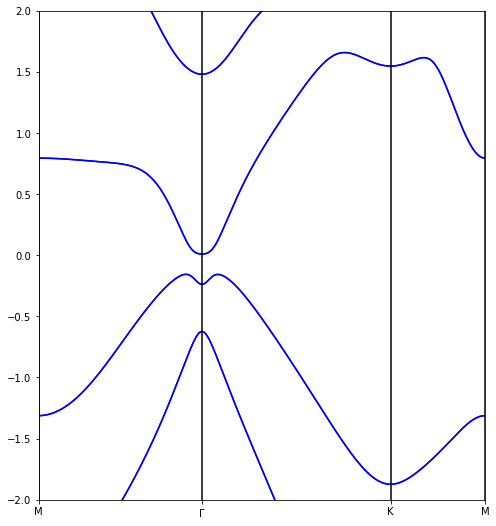

In [5]:
# Plot the band structure
fig, ax = plt.subplots(1, 1, figsize=(8,9))
ymin, ymax = (-2, 2)

for ibnd in range(nbands):
    ax.plot(lk, bands[:, ibnd] - EFermi, 'b')

ax.set_xlim(min(lk), max(lk))
ax.set_ylim(ymin, ymax)
ax.xaxis.set_ticks(xtick)
ax.set_xticklabels(xtick_label)
for tick in xtick:
    ax.plot([tick, tick], [ymin, ymax], 'k')
    

#### 4 Spin Texture

Calculate the spin texture, i.e. the spin moment of the eigenstates, along the same k-path as in 3.

_Hints:_
- The spin moment for a given k-point can be calculated with sisl, using the ```spin_moments``` routine See [```sisl.physics.Hamiltonian.spin_moment```](http://zerothi.github.io/sisl/docs/latest/api-generated/sisl.physics.Hamiltonian.html?highlight=spin_moment#sisl.physics.Hamiltonian.spin_moment).
```
>>> H = Hamiltonian(...)
>>> Sx, Sy, Sz = H.spin_moment().T
```
- The ``sisl.BrillouinZone`` or ``sisl.BandStructure`` object can be used evaulate functions for all k-points. Using the ```call``` routine:
```
>>> H = Hamiltonian(...)
>>> bz = BrillouinZone(H)
>>> bz.eigh() == bz.call(H.eigh)
```

In [6]:
# Calculate the spin moments for all eigenstates along the k-path.
spin_moments = kpath.call(H.spin_moment)

A convient way to visualize the spin texture is coloring the bands according to the spin moment. The template below can be used to plot the spin texture. 

_For reference on how to create multi coloured lines refer to the matplotlib [documentation](https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html)._

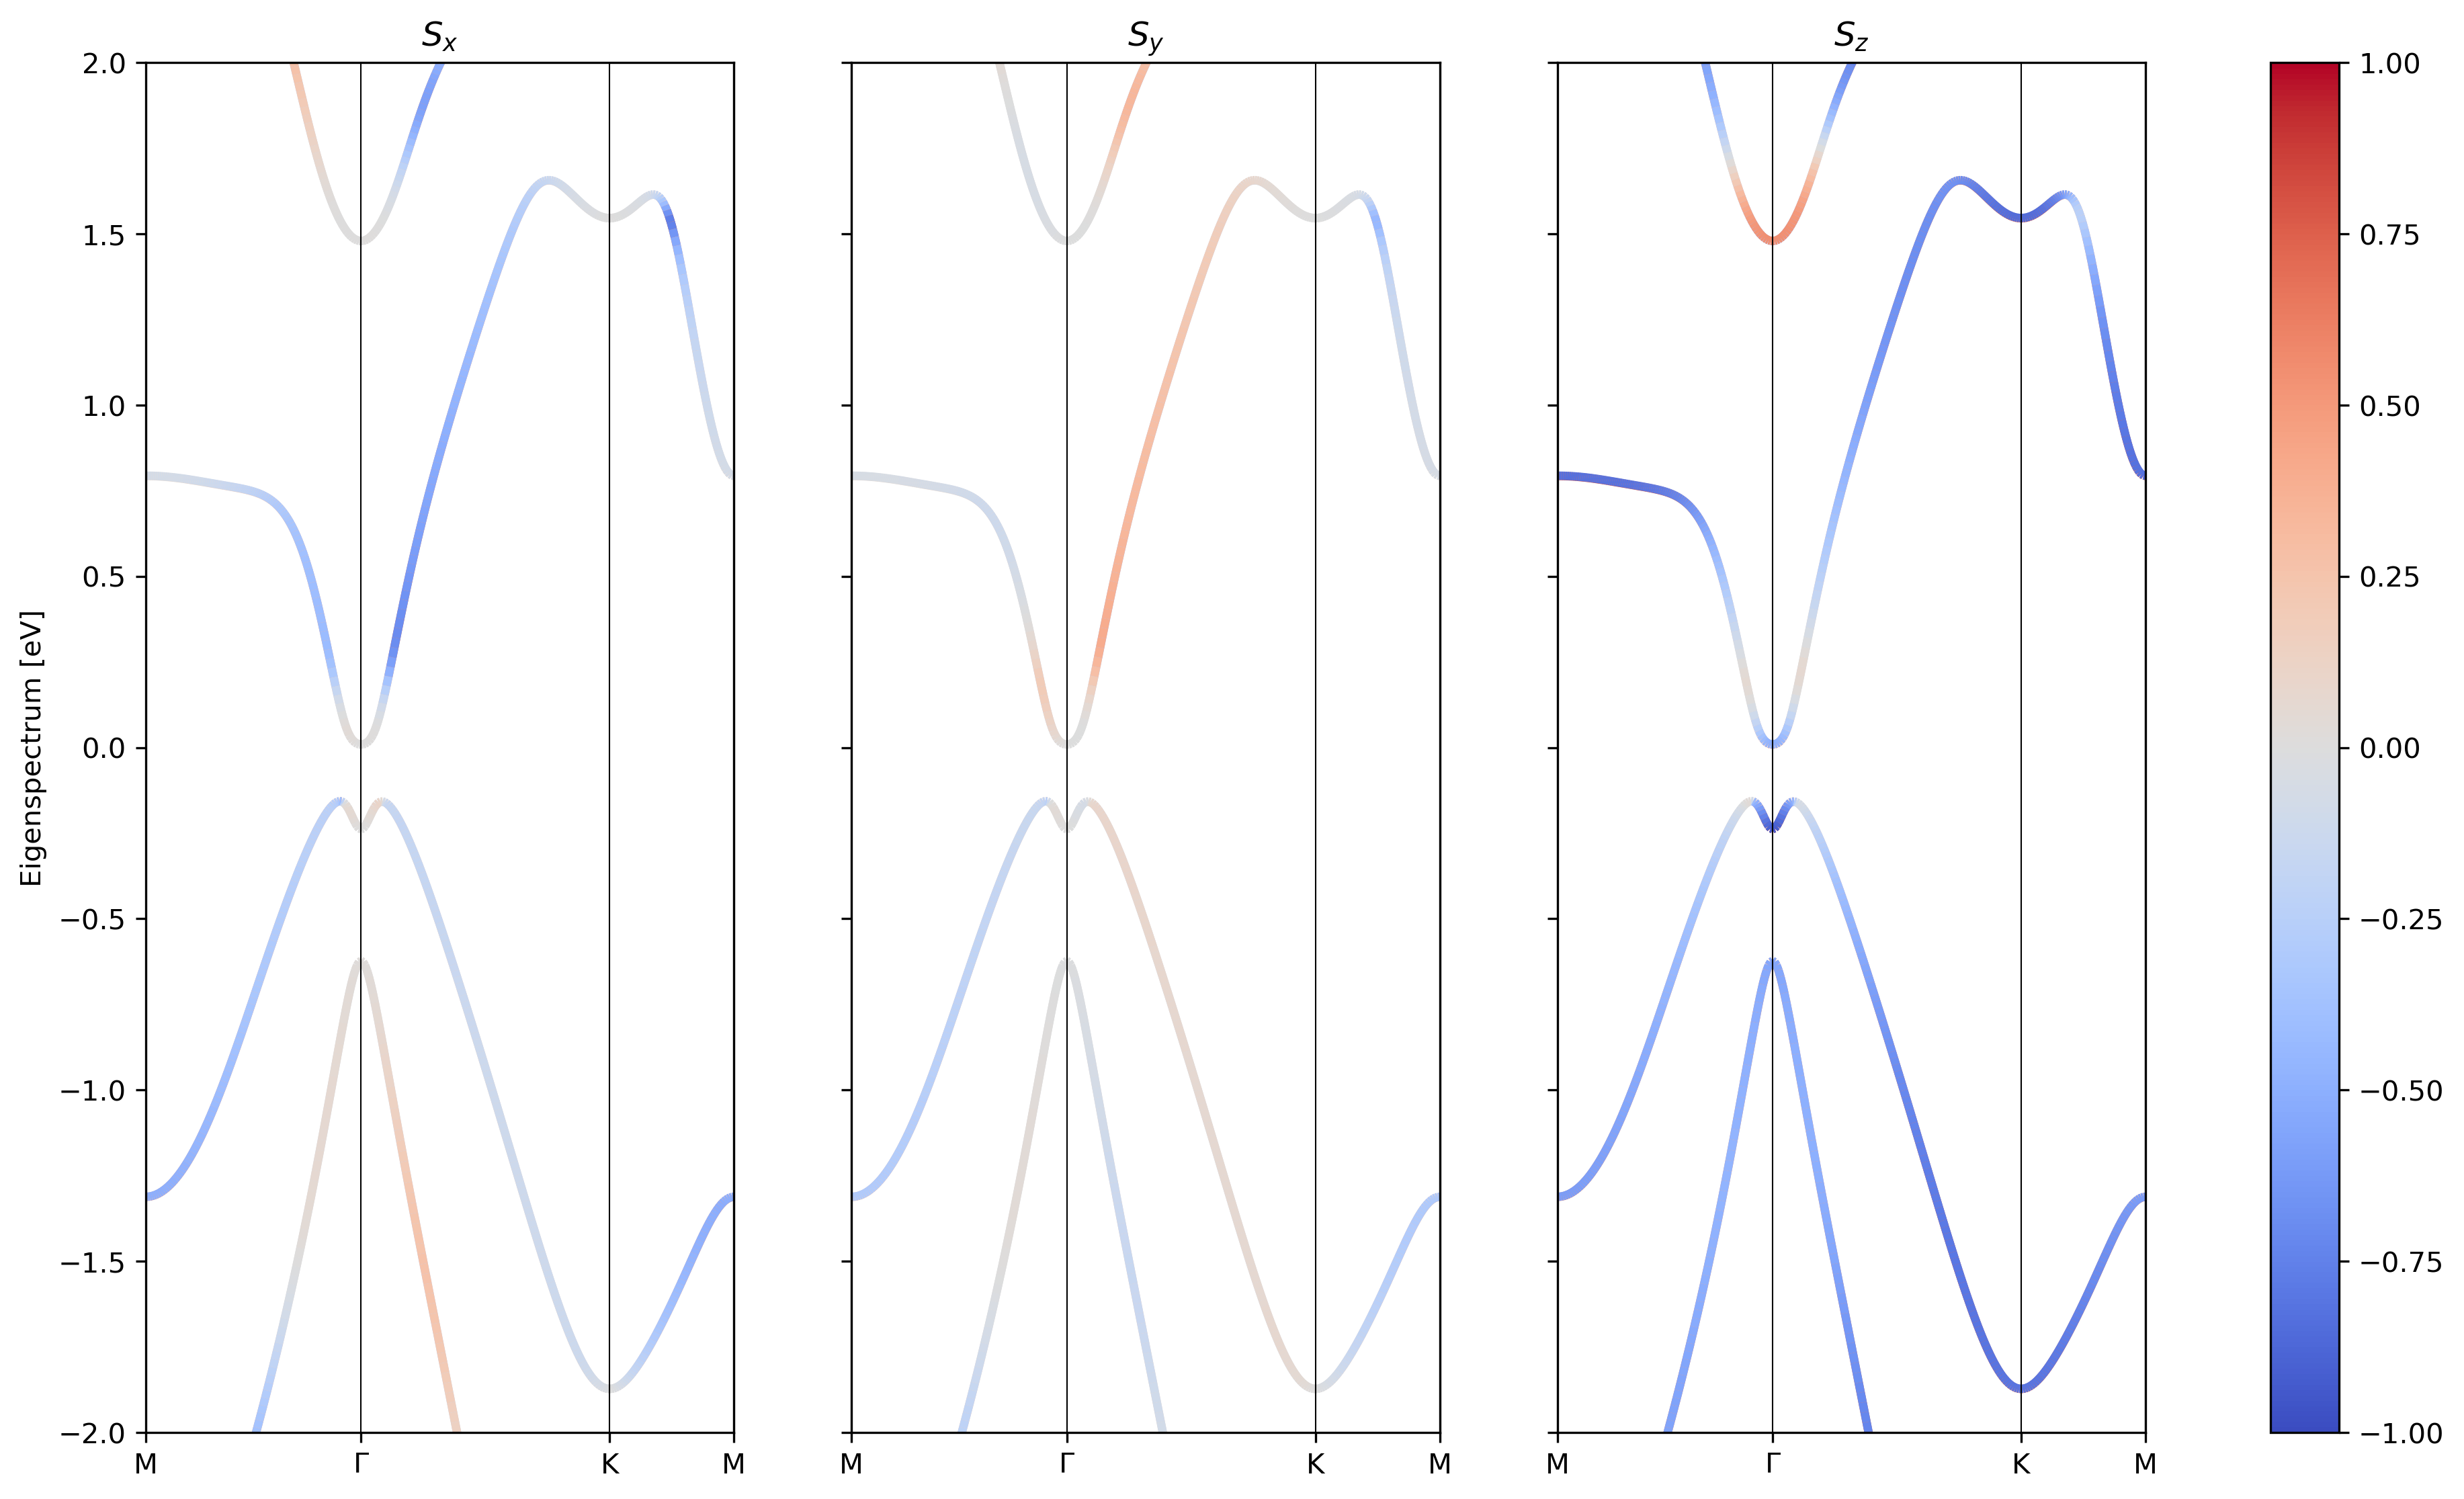

In [7]:
def plot_spin_texture(bands, spin_moments):
    # Create a figure with three subplot one for each component of the spin moment
    fig, axes = plt.subplots(1, 3, figsize=(16, 9), dpi=300, sharex=True, sharey=True)

    # Set the range of z-values, which will determine the color.
    norm = plt.Normalize(-1, 1)

    for icomp, component in enumerate(['$S_x$', '$S_y$', '$S_z$']):
        for ibnd in range(bands.shape[1]):
            # Create line segments from one point on the x-axis to the next.
            # These segments can be colored individually
            points = np.array([lk, bands[:, ibnd]-EFermi]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            # Create a map that color the segments accord to the z-value
            #   cmap: specifies the colormap used to convert z-values into colors
            lc = LineCollection(segments, cmap='coolwarm', norm=norm)
            lc.set_array(spin_moments[:, ibnd, icomp])
            lc.set_linewidth(3)

            # Add the LineCollection to the subplot
            line = axes[icomp].add_collection(lc)
        axes[icomp].set_title(component)

    # All subplots share the same axis settings, so we can just adjust them once    
    axes[0].set_xlim(min(lk), max(lk))
    axes[0].set_ylim(-2, 2) 
    axes[0].set_ylabel('Eigenspectrum [eV]')
    axes[0].xaxis.set_ticks(xtick)
    axes[0].set_xticklabels(xtick_label)

    for axis in axes:
        for tick in xtick:
            axis.plot([tick, tick], [ymin, ymax], 'k', linewidth=0.5)

    fig.colorbar(line, ax=axes.ravel().tolist())
    plt.show()

plot_spin_texture(bands, spin_moments)

What happens when every other band is plotted, instead of all of them at the same time? Why?

Bands with even indices:

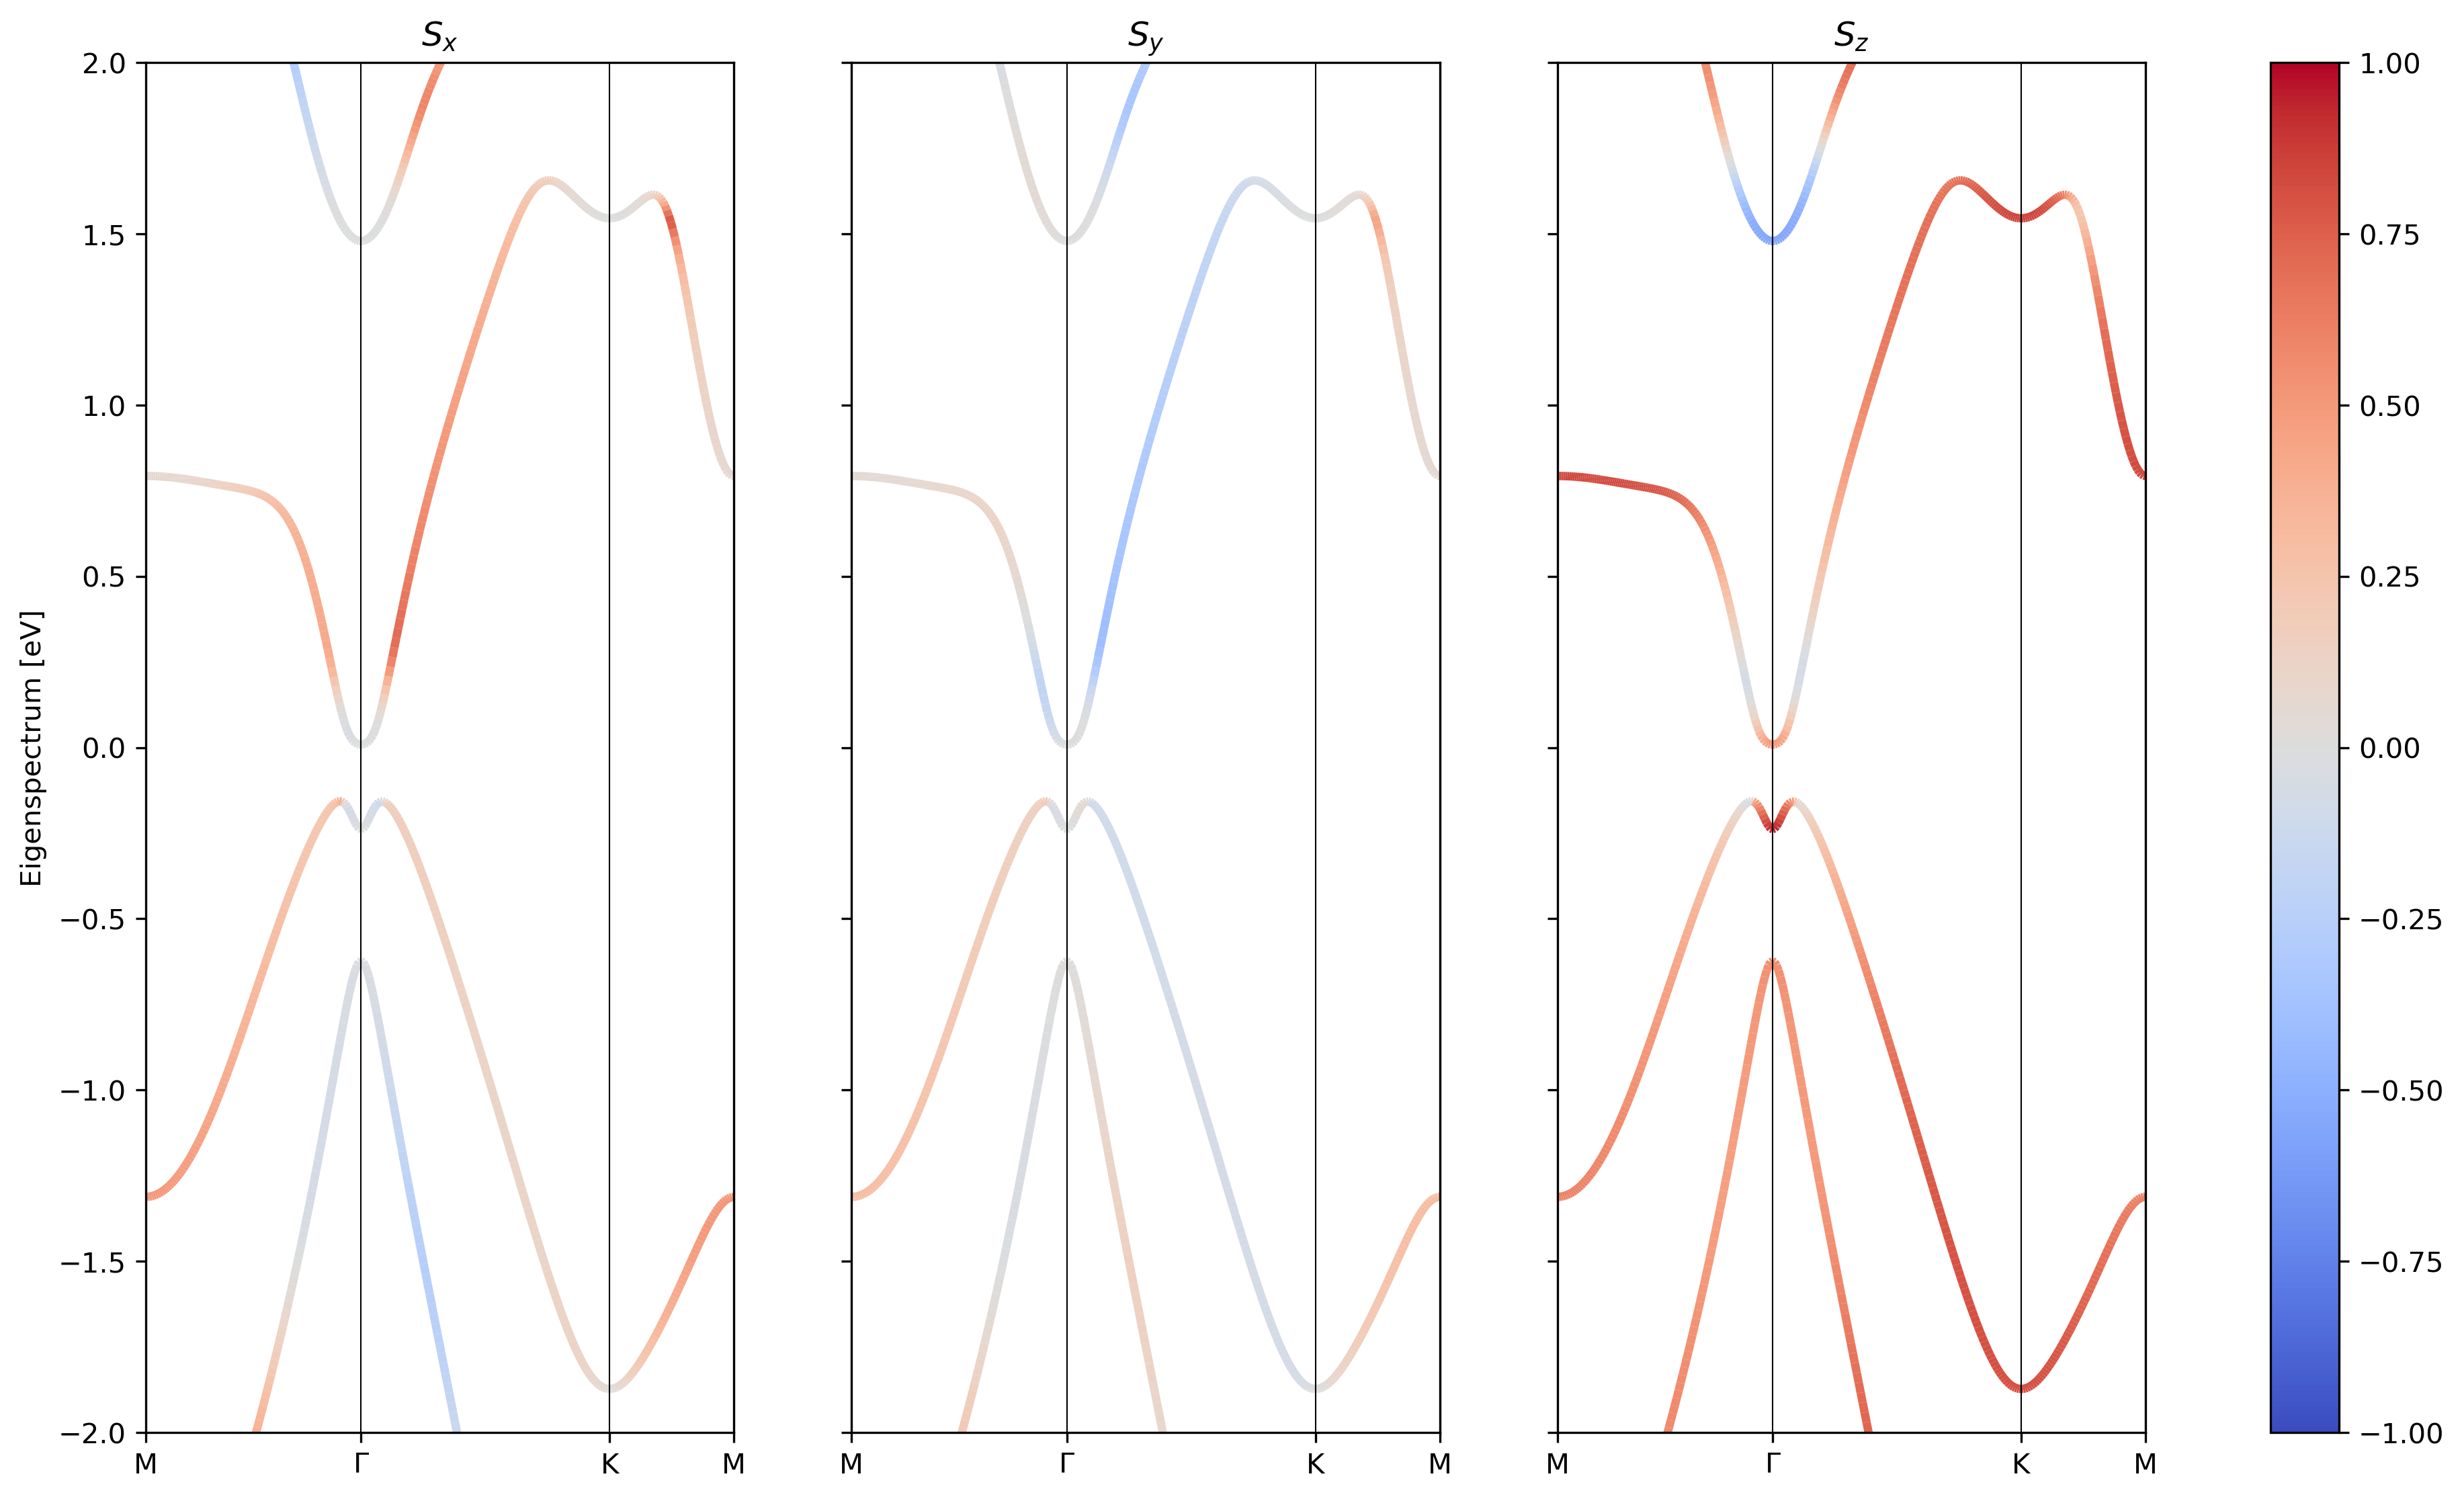

In [8]:
plot_spin_texture(bands[:,::2], spin_moments[:,::2])

Bands with odd indices:

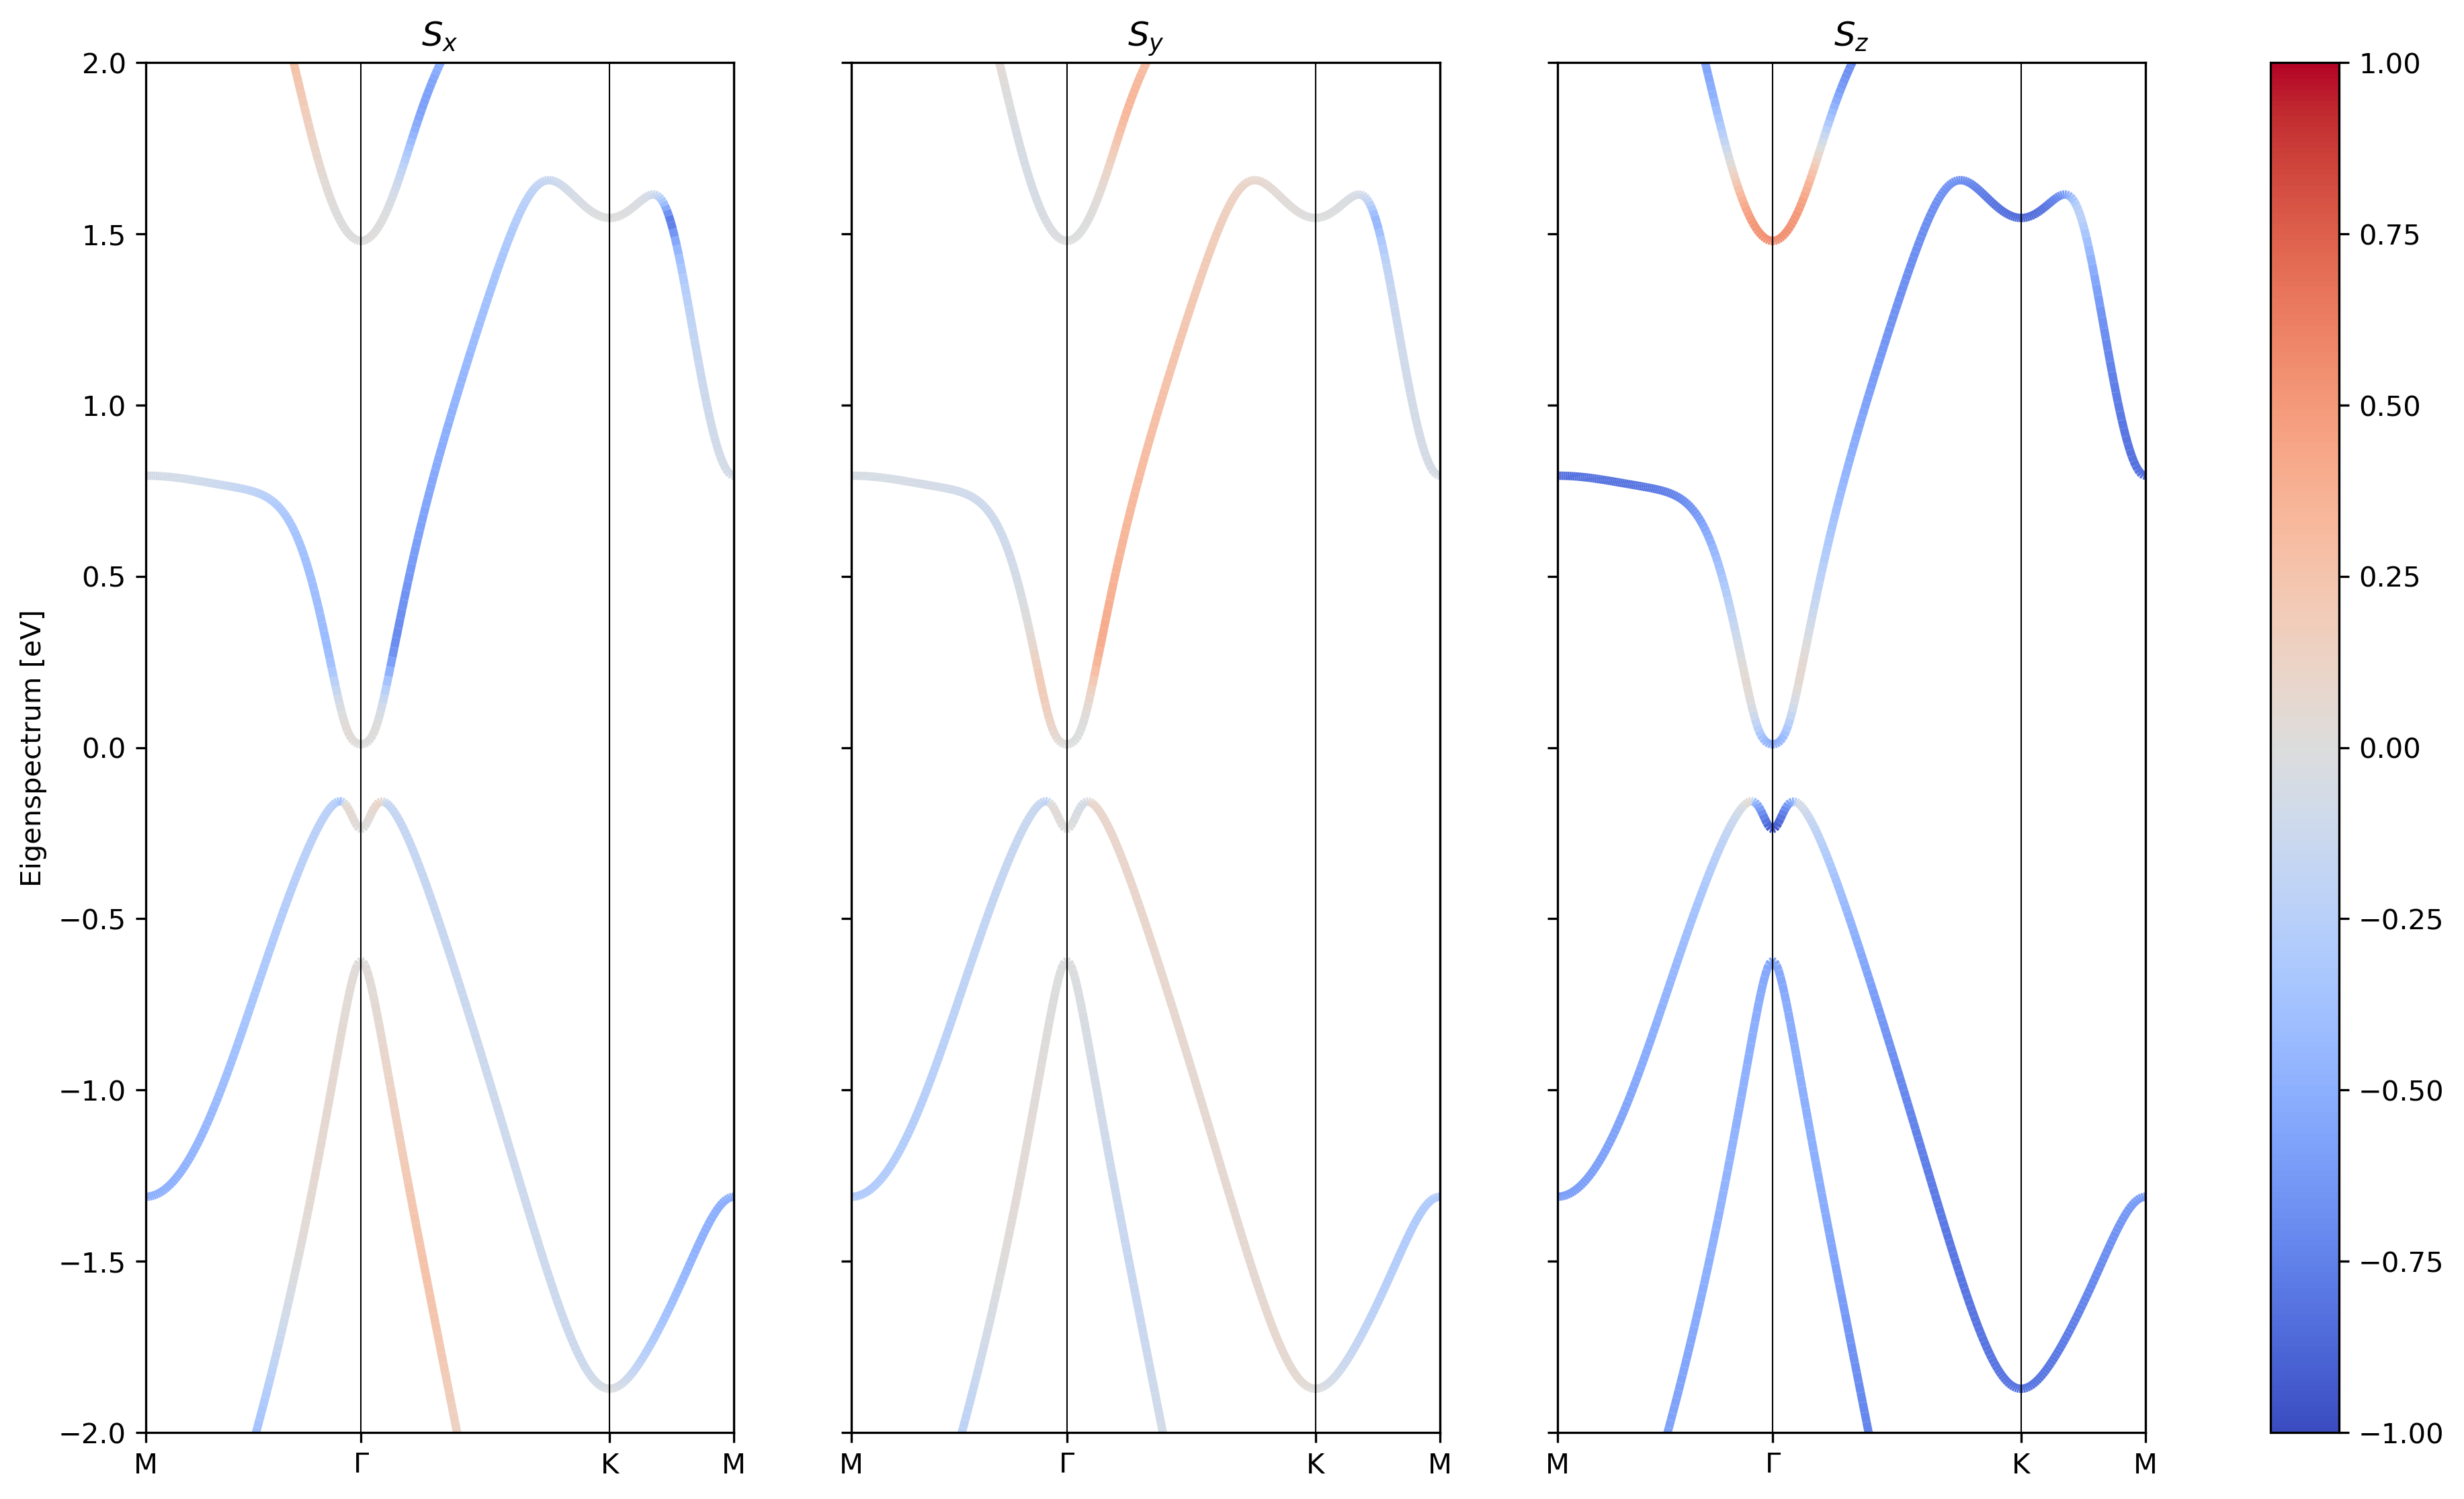

In [9]:
plot_spin_texture(bands[:,1::2], spin_moments[:,1::2])

The system is time-reversal invariant. Therefore, all states appear in degenrate Kramer pairs. The two states forming the Kramer pair are mapped onto each other by the time-reversal operator $T$. Since, $T$ flips the spin of any state, the two states in every pair carry opposite spins.

TWe can see that the sum of the spin moments are indeed zero:

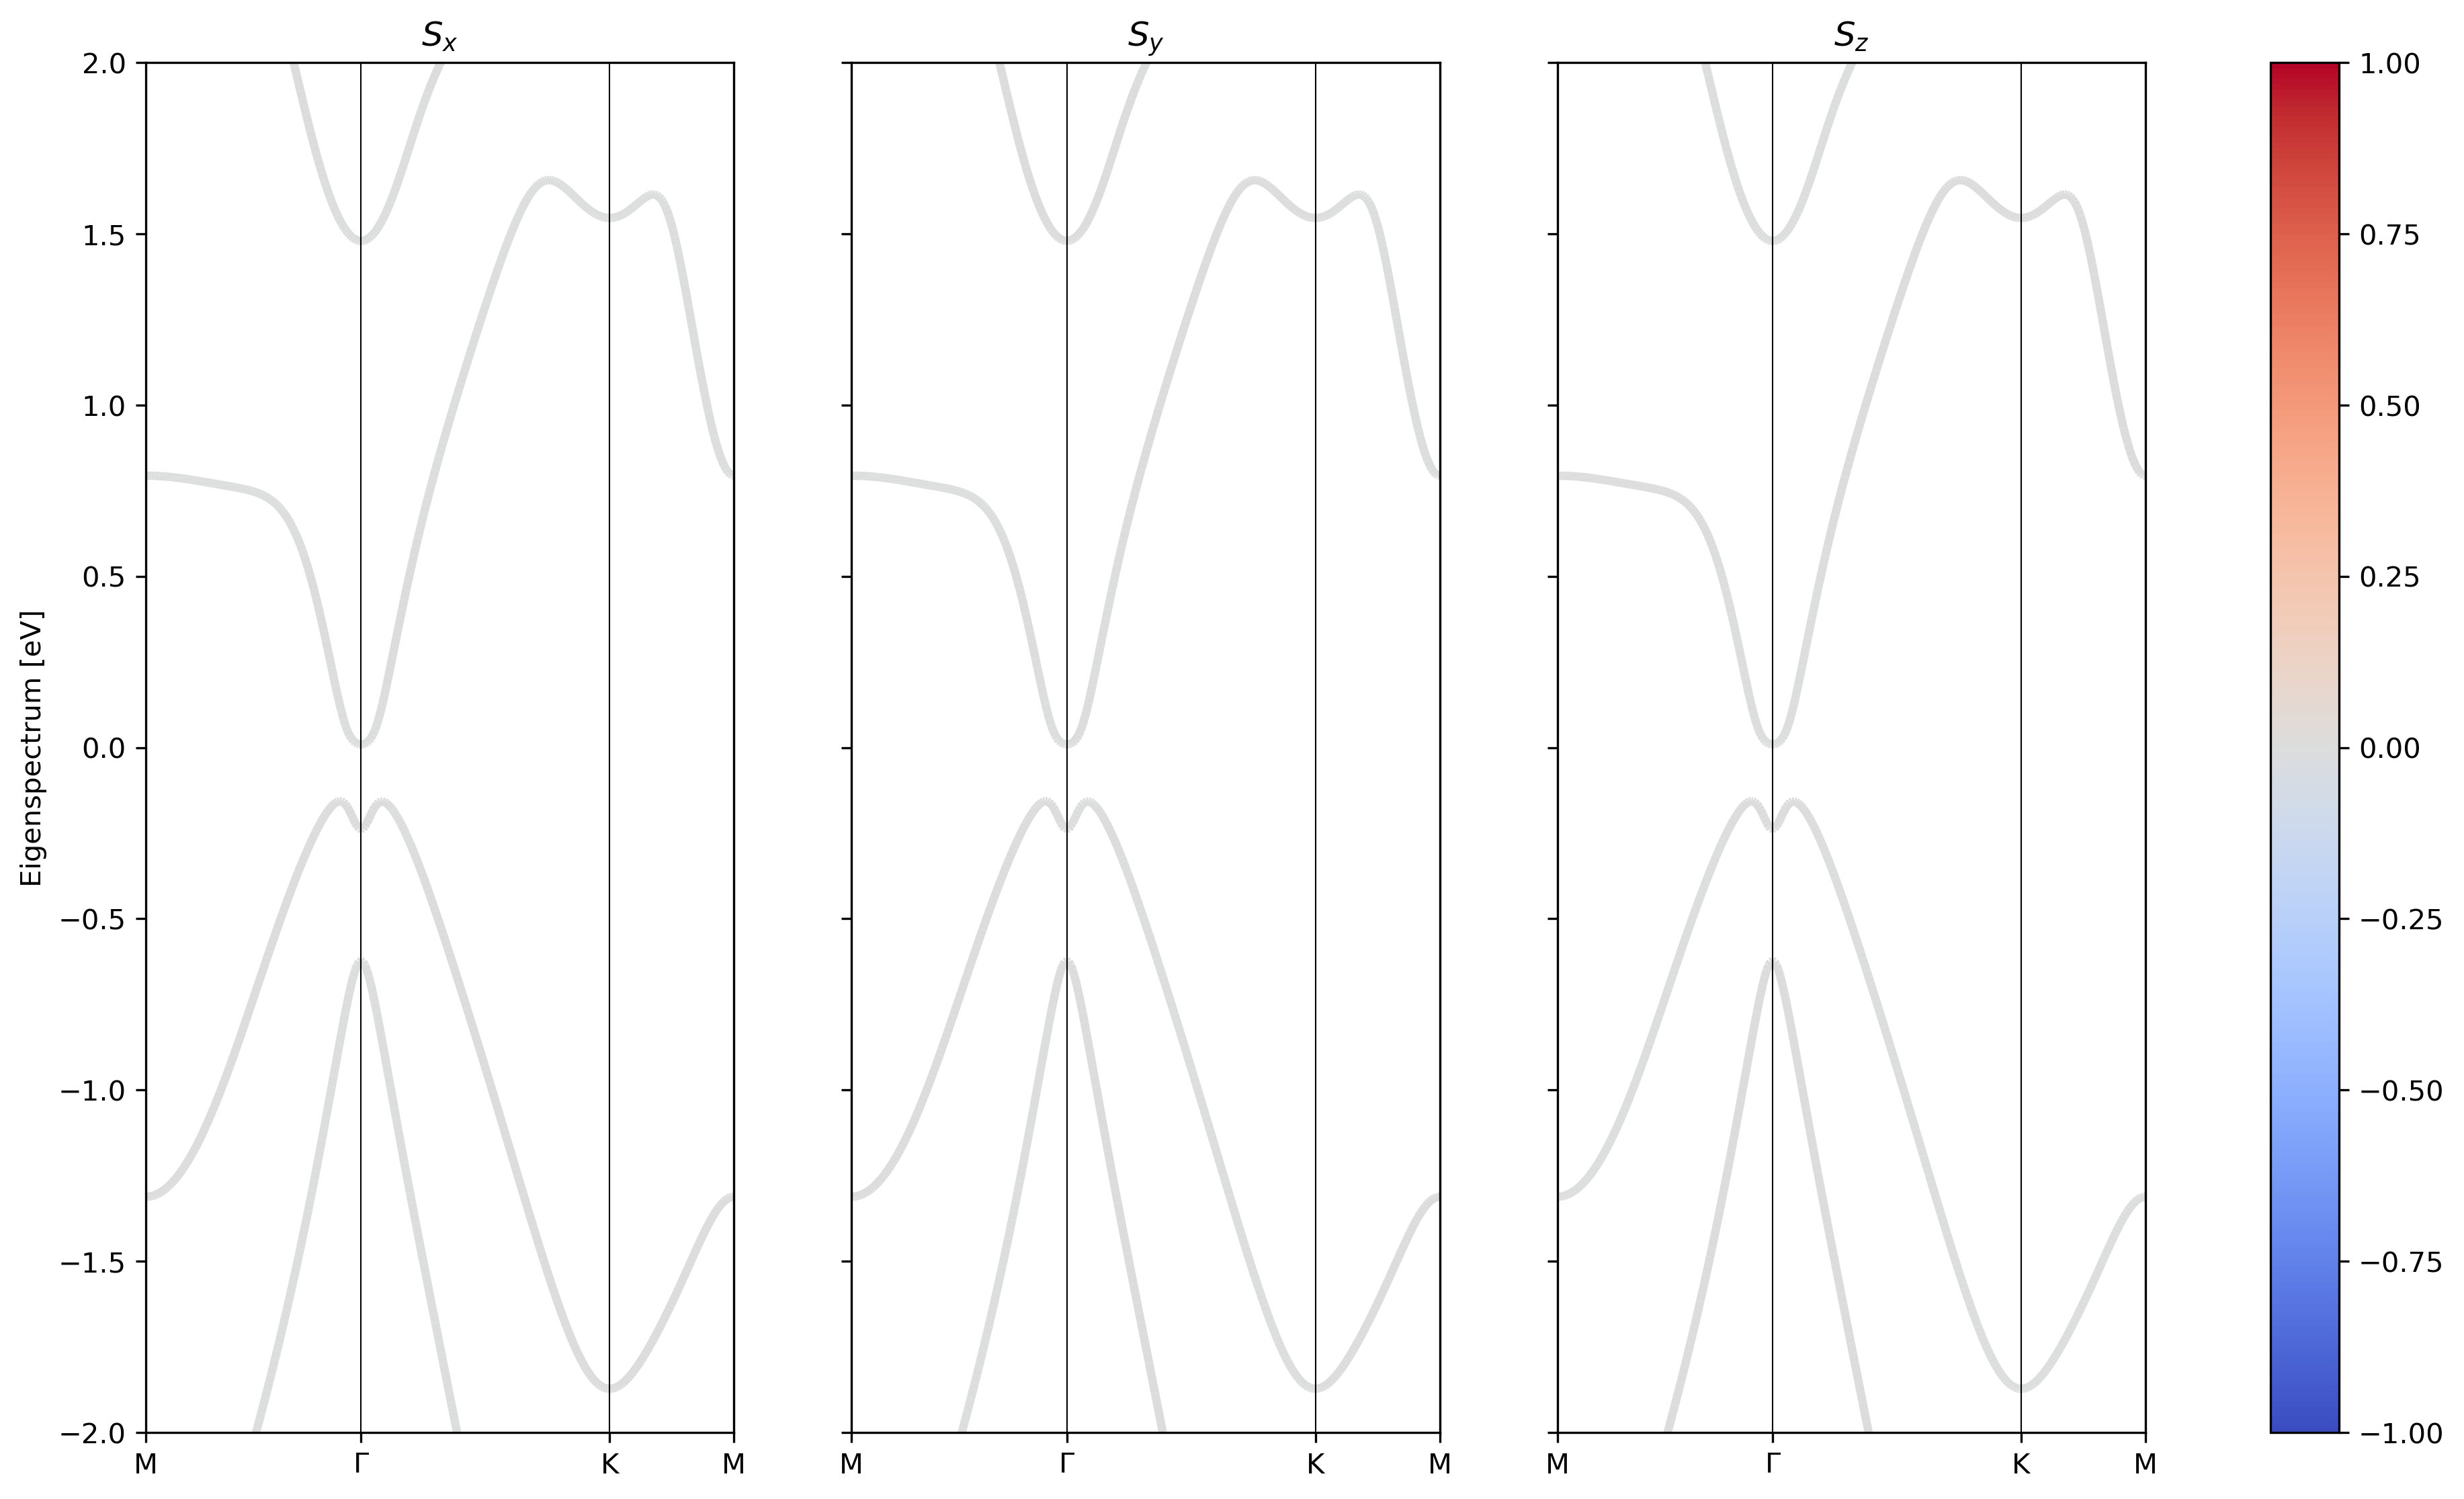

In [10]:
plot_spin_texture(bands[:,1::2], spin_moments[:,0::2]+spin_moments[:,1::2])